In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

import env
import wrangle
import split_scale
import features

#### Acquire and summarize data

In [2]:
df = wrangle.wrangle_zillow()

In [ ]:
df.head()

In [3]:
df.describe()

,id,bathrooms,bedrooms,sqft,tax_value
count,15982.000000,15982.000000,15982.000000,15982.000000,1.598200e+04
mean,42320.988737,2.214992,3.252597,1836.581905,4.633691e+05
std,6529.896396,1.027066,0.950211,985.314844,6.435119e+05
min,1772.000000,1.000000,1.000000,320.000000,7.584000e+03
25%,36972.250000,2.000000,3.000000,1233.000000,1.817542e+05
50%,41635.000000,2.000000,3.000000,1592.000000,3.202605e+05
75%,47990.750000,3.000000,4.000000,2161.750000,5.287630e+05
max,53503.000000,20.000000,25.000000,26345.000000,1.912982e+07


In [43]:
df.dtypes

id             int64
bathrooms    float64
bedrooms     float64
sqft         float64
tax_value    float64
dtype: object

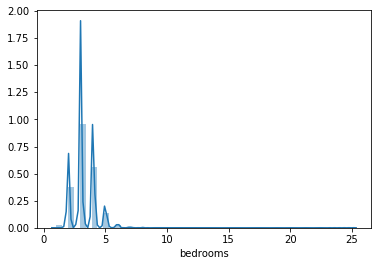

In [5]:
sns.distplot(df['bedrooms'])

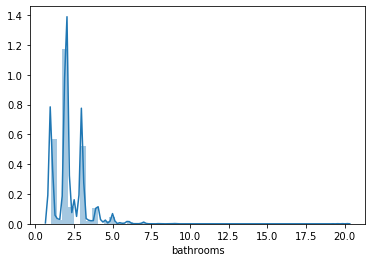

In [6]:
sns.distplot(df['bathrooms'])

(0, 10000)

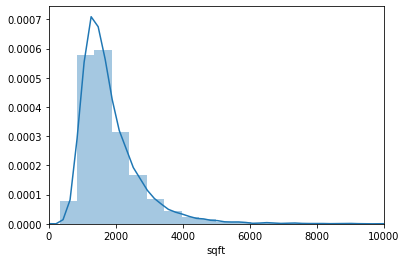

In [7]:
sns.distplot(df['sqft'])
plt.xlim(0,10000)

(0, 1000000)

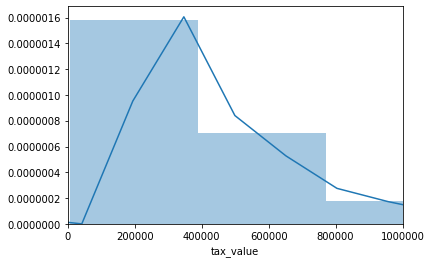

In [20]:
sns.distplot(df['tax_value'])
plt.xlim(0,1_000_000)

#### Prep and clean data

In [ ]:
#dropping id and transactiondate from table before scaling
df.drop('id',axis=1,inplace=True)
df.drop('transactiondate',axis=1,inplace=True)

In [57]:
df.head(1)

,bathrooms,bedrooms,sqft,tax_value
0,2.0,4.0,1604.0,498347.0


#### Split and Scale

In [58]:
train, test = split_scale.split_my_data(df,train_ratio=.8,seed=123)

In [59]:
scaler, train_scaled, test_scaled = split_scale.standard_scaler(train,test)

In [60]:
X_train = train.drop(columns='tax_value')
y_train = train[['tax_value']]
X_test = test.drop(columns='tax_value')
y_test = test[['tax_value']]

#### Data exploration

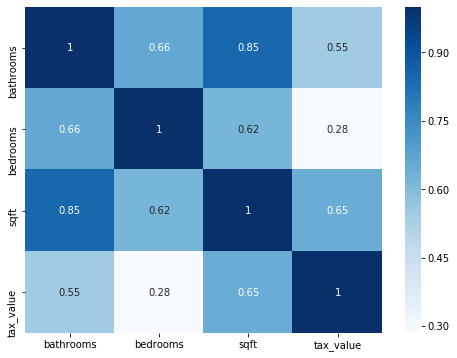

In [61]:
plt.figure(figsize=(8,6))
cor = train.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Blues)
plt.show()

In [62]:
import statsmodels.api as sm

#OLS object to analyze features

ols_model = sm.OLS(y_train,X_train)
fit = ols_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              tax_value   R-squared (uncentered):                   0.632
Model:                            OLS   Adj. R-squared (uncentered):              0.632
Method:                 Least Squares   F-statistic:                              7319.
Date:                Thu, 17 Oct 2019   Prob (F-statistic):                        0.00
Time:                        16:15:54   Log-Likelihood:                     -1.8549e+05
No. Observations:               12785   AIC:                                  3.710e+05
Df Residuals:                   12782   BIC:                                  3.710e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bathrooms   6.002e+04   8208.523      7.312      0.000    4.39e+04    7.61e+04
bedrooms   -1.561e+05   4007.257    -38.959      0.000   -1.64e+05   -1.48e+05
sqft         457.7525      8.143     56.215      0.000     441.791     473.714
==============================================================================
Omnibus:                    18801.038   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17805872.249
Skew:                           8.582   Prob(JB):                         0.00
Kurtosis:                     185.018   Cond. No.                     4.17e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

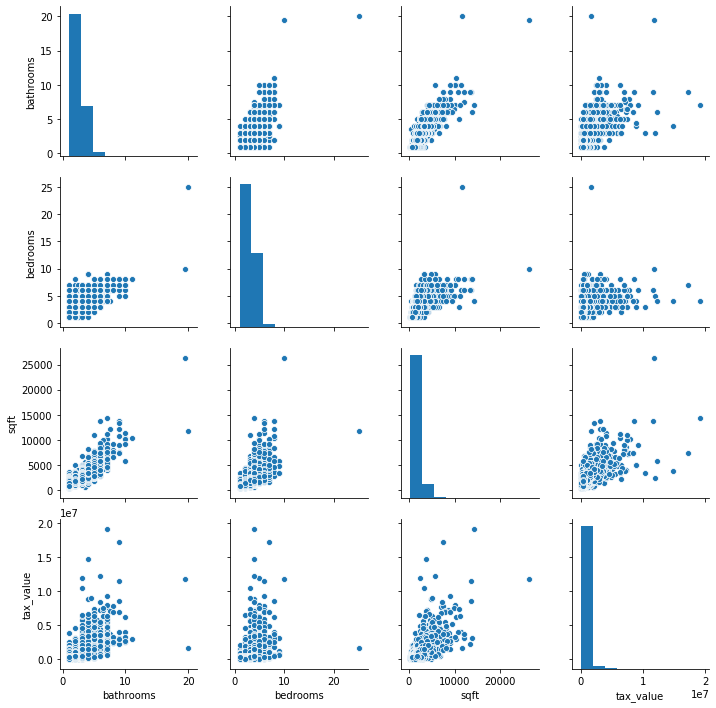

In [63]:
sns.pairplot(df)

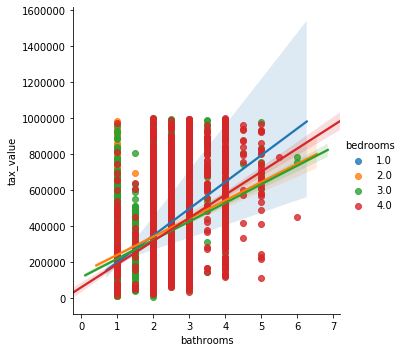

In [75]:
df_bedrooms = (df['bedrooms'] < 5) & (df['tax_value'] < 1000000)
g = sns.lmplot(x='bathrooms',y='tax_value',hue='bedrooms',data=df_four_bed_or_less)

In [74]:
df_four_bed_or_less = df[df_bedrooms]

#### Modeling & Evaluation MVP

In [77]:
from sklearn.linear_model import LinearRegression
#pick model type, Linear Regression for the MVP baseline
lm1 = LinearRegression()

In [82]:
#fit and train model
lm1.fit(X_train,y_train)
lm1_y_intercept = lm1.intercept_
lm1_coefficients = lm1.coef_

print('{} = b + m1 * {} + m2 * {}'.format(y_train.columns[0], X_train.columns[0],X_train.columns[1]))
print('    y-intercept  (b): %.2f' % lm1_y_intercept)
print('    coefficient (m1): %.2f' % lm1_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm1_coefficients[0][1])

tax_value = b + m1 * bathrooms + m2 * bedrooms
    y-intercept  (b): -33592.49
    coefficient (m1): 60947.32
    coefficient (m2): -146174.77


In [79]:
#target prediction

y_pred_lm1 = lm1.predict(X_train)

In [81]:
mse_lm1 = mean_squared_error(y_train,y_pred_lm1)
print("linear model\n  mean squared error: {:.3}".format(mse_lm1)) 

r2_lm1 = r2_score(y_train,y_pred_lm1)
print('  {:.2%} of the variance in the house price can be explained by the num of bathrooms, num of bedrooms, and sq ft of house.'.format(r2_lm1))

linear model
  mean squared error: 2.34e+11
  44.47% of the variance in the house price can be explained by the num of bathrooms, num of bedrooms, and sq ft of house.


In [84]:
#establish baseline
from math import sqrt
y_pred_baseline = np.array([y_train.mean()[0]]*len(y_train))
MSE = mean_squared_error(y_train,y_pred_baseline)
SSE = MSE * len(y_train)
RMSE = sqrt(MSE)

evs = explained_variance_score(y_train,y_pred_baseline)

